# T4SA 2.0
This notebook contains the code to create the new T4SA 2.0 dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from ast import literal_eval
from IPython.display import display
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

BASE_DIR = "/content/drive/MyDrive/Thesis/"

DATASET_T4SA1_DIR = BASE_DIR + "dataset/t4sa/"
BT4SA1_DIR = DATASET_T4SA1_DIR + "new_text_predictions/bt4sa_filtered_70/"

DATASET_T4SA2_DIR = BASE_DIR + "dataset/t4sa_2.0/"
DUPLICATE_DIR = DATASET_T4SA2_DIR + "filtering/duplicates/" 
IMG_DIR = DATASET_T4SA2_DIR + "img/"

DATASET_VERSION_1_DIR = DATASET_T4SA2_DIR + "version_1/"
DATASET_VERSION_2_DIR = DATASET_T4SA2_DIR + "version_2/"
DATASET_VERSION_3_DIR = DATASET_T4SA2_DIR + "version_3/"
DATASET_VERSION_4_DIR = DATASET_T4SA2_DIR + "version_4/"

# Feature Extractor

In [ ]:
!pip install -q faiss-cpu
import faiss

BATCH_SIZE = 100
IMAGE_SIZE = (224, 224)
TEST_DIR = DATASET_DIR + "test/15368/"

In [ ]:
# Utility

def load_image_tf(path):
  '''Decodes the image specified by the path in input and applies some preprocessing to it.'''
  image_data = tf.io.read_file(TEST_DIR + path)   # read image file
  image = tf.image.decode_image(image_data, channels=3, expand_animations=False)  # decode image data as RGB (do not load whole animations, i.e., GIFs)
  image = tf.image.resize(image, (224, 224)) # resize
  image = tf.keras.applications.resnet50.preprocess_input(image)   # preprocess the image as is done in the original ResNet
  
  return image
  

In [ ]:
file_list = os.listdir(TEST_DIR)

n_images = len(file_list)
print("Extracting features for", n_images, "files...")

# Buld a tensorflow dataset
image_batches_ds = tf.data.Dataset.from_tensor_slices((file_list))

# Map the dataset with the preprocessing function
image_batches_ds = image_batches_ds.map(
  lambda x: (load_image_tf(x)),  # path -> image
  num_parallel_calls=tf.data.AUTOTUNE,  # load in parallel
  deterministic=True  # keep the order (we will shuffle afterward if needed)
).batch(BATCH_SIZE)  # batch the dataset


# Show images before preprocessing
plt.figure(figsize=(12, 12))

for images in image_batches_ds.take(2):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

Extracting features for 11802 files...


In [ ]:
# Use ResNet50 to extract features from images
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + (3,),
    pooling="max"
  )

# Build a functional model to get the output from a middle layer with 1024 feature maps of size 14x14,
# which are then compressed in an array of 1024 feature thanks to a global max pooling that takes 
# the maximum of each feature map  
inputs = tf.keras.Input(shape=(224, 224, 3))

res_net = tf.keras.Model(inputs=base_model.input,
                         outputs=base_model.get_layer('conv4_block6_out').output,
                         name="res_net"
                         )
x = res_net(inputs)
output = tf.keras.layers.GlobalMaxPooling2D()(x)
feature_extractor = tf.keras.Model(inputs=inputs, outputs=output)

feature_extractor.summary()

In [ ]:
# Start the extraction of features for all the images in the dataset
temp = []

# Apply the model to each batch
for batch in tqdm(image_batches_ds.as_numpy_iterator(), total=n_images):
  image_feature_vectors = feature_extractor(batch).numpy()   
  for image_feature_vector in image_feature_vectors:  
    temp.append(image_feature_vector)

# Store the features as an numpy array
features = np.asarray(temp)

In [ ]:
print("Feature shape:", features.shape)
d = features.shape[1]

nlist = 100  # number of posting lists = number of clusters in k-means

quantizer = faiss.IndexFlatL2(d)  # this is the index that will contain the
                                  # clusters and will be used to search the
                                  # nearest centroids

# using the IndexIVFFlat of the FAISS library that implements
# Voronoi partitioning, i.e. well-known Vector Quantization approach
index = faiss.IndexIVFFlat(quantizer, d, nlist)

print("Training the index...")
index.train(features)  # this index must be trained (run k-means) to be used
print("Training end, is_trained: ", index.is_trained)

index.add(features)  # now we can add the data


# query image to check that duplicate and near duplicate are detected
# I inserted one duplicate and a near duplicate 
q = features[3]
q = np.expand_dims(q, axis=0)

In [ ]:
# Plot the query image
img = mpimg.imread(TEST_DIR + file_list[3])
imgplot = plt.imshow(img)
plt.title("Query Image")
plt.axis("off")


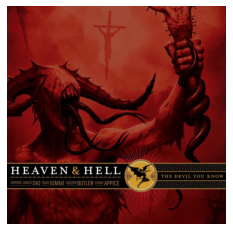

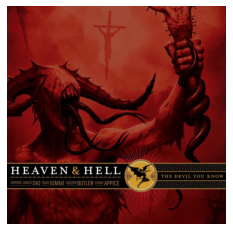

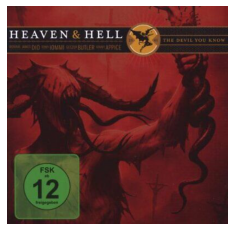

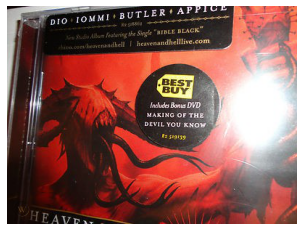

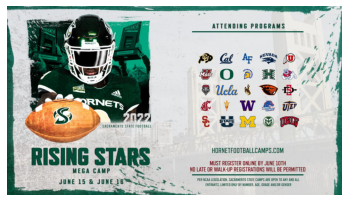

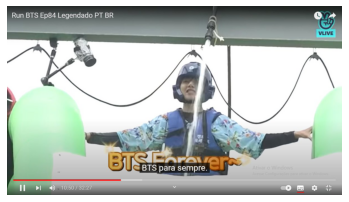

In [ ]:
# return the k-NN
k = 30
index.nprobe = 10


distances, indexes = index.search(q, k)  # D: a (N,k)-shaped matrix where D[i,j] contains the L2 distance of the j-th neighbor of the i-th query.
                                          # I: a (N,k)-shaped matrix where I[i,j] contains the index of the j-th neighbor of the i-th query.

# Normalization of the distances to fix them in the range [0,1]
distances = normalize(distances)

# Show the K-NN of the query (of course one is the query itself)
for i in indexes[0]:
  img = mpimg.imread(TEST_DIR + file_list[i])
  imgplot = plt.imshow(img)
  plt.axis("off")
  plt.show()

In [ ]:
threshold = 0.15

img_with_duplicate = []
list_of_duplicates= []

# Iterate for all the images
for i in range(len(distances)):
  
  # Get the distance vector of the current image
  distance_vector = distances[i]      
  
  # Filter using a mask with only the distances below a threshold
  mask_duplicates = distance_vector < threshold
  distance_vector = distance_vector[mask_duplicates]
  
  # If the image has at least one duplicate, then a list of its duplicate is created
  if len(distance_vector) > 1:
    index_vector = indexes[i]         # Get the index vector of the current image
    img_with_duplicate.append(file_list[index_vector[0]])
    index_vector = index_vector[mask_duplicates]

    # Remove the first item of the list since that contains the image itself (and of course has always distance 0)
    list_of_duplicates.append([file_list[i] for i in index_vector[1:]])

# Create a dataframe with all the duplicates
duplicate_df = pd.DataFrame({"duplicated image":img_with_duplicate, "duplicates": list_of_duplicates}) 

# T4SA 2.0 labeling

In [ ]:
def check_label_with_filter_flat(row):
  '''Returns the string label corresponding to the argmax on the predictions only if above the threshold, otherwise return 'Too low'.'''
  THRESHOLD = 0.70
  maximum_value = max(row[1:4]) # In column 1 there is the TWID
  if row[1] == maximum_value:
    label = '0'
  elif row[2] == maximum_value:
    label = '1'
  else:
    label = '2'
  if maximum_value > THRESHOLD:
    return label
  else:
    return 'Too low'


def check_label_with_filter_70_90(row):
  '''Returns the string label corresponding to the argmax on the predictions only if above the threshold, otherwise return 'Too low'.'''
  THRESHOLD_NEGATIVE = 0.70
  THRESHOLD_POSITIVE = 0.90
  maximum_value = max(row[1:4])  # In column 1 there is the TWID
  if row[1] == maximum_value:
    label = '0'
    threshold = THRESHOLD_NEGATIVE
  elif row[2] == maximum_value:
    label = '1'
    threshold = THRESHOLD_POSITIVE
  else:
    label = '2'
    threshold = THRESHOLD_POSITIVE

  if maximum_value > threshold:
    return label
  else:
    return 'Too low'


def check_label(row):
  '''Returns the string label corresponding to the argmax on the predictions.'''
  maximum_value = max(row[1:4])  # In column 1 there is the TWID
  if row[1] == maximum_value:
    label = '0'
  elif row[2] == maximum_value:
    label = '1'
  else:
    label = '2'
  return label

def plot_dataset_composition(dataset, saving_name=None):
  '''Plot the dataset distribution of classes in a pie chart and also save it with the name specified as input.'''

  dataset["label"] = dataset["label"].apply(int)   # convert all the labels to int
  results_filtered = {}

  for i in range(3):
    results_filtered[i] = len(dataset[dataset["label"] == i])
  print(f"- Number of Positive: {results_filtered[2]:9,d}")
  print(f"- Number of Neutral:  {results_filtered[1]:9,d}")
  print(f"- Number of Negative: {results_filtered[0]:9,d}")
  print("-"*32)
  print(f"Total: {sum(results_filtered.values()):24,d}")
  
  labels = ["Negative"," Neutral", "Positive"]
  colors = ["#FF0000", "#FFEC00", "#52D726"]   
  
  fig1, ax1 = plt.subplots()
  ax1.pie(results_filtered.values(),  labels=labels, autopct='%1.1f%%', colors=colors)
  ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

  if saving_name:
    plt.savefig(IMG_DIR + saving_name, dpi=1200)  # save the pie chart

  plt.show()

## Labels without threshold

Plot statistic on the text predictions of t4sa2.0...
- Number of Positive: 1,206,158
- Number of Neutral:  1,403,683
- Number of Negative:   356,002
--------------------------------
Total:                2,965,843


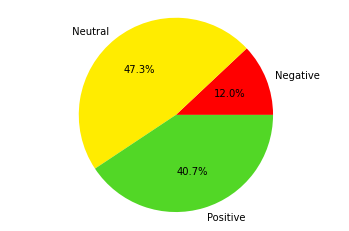

In [ ]:
# Load the file with all the text predictions
t4sa2_text_predictions = pd.read_csv(DATASET_T4SA2_DIR + "t4sa2.0_text_prediction_final.csv")

# Assign a label to all tweets considering the predictions
t4sa2_text_predictions['label'] = t4sa2_text_predictions.apply(check_label, axis=1)
t4sa2_text_predictions['label'] = t4sa2_text_predictions['label'].apply(int)

print("Plot statistic on the text predictions of t4sa2.0...")
plot_dataset_composition(t4sa2_text_predictions, saving_name="text_t4sa2.eps")

Plot statistic on all the images of t4sa2.0 with duplicates...
- Number of Positive: 1,593,484
- Number of Neutral:  1,708,195
- Number of Negative:   433,172
--------------------------------
Total:                3,734,851


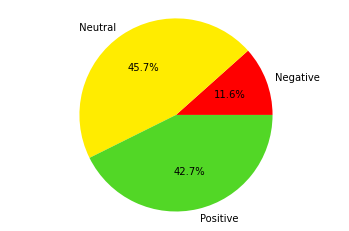

In [ ]:
# Load the dataframe from the file that contains the original predictions
imgs_t4sa2 = pd.read_csv(DATASET_T4SA2_DIR + "all_imgs_filtered_final.csv")

# Assign labels to images merging on the Tweet identifier
t4sa2_img = pd.merge(imgs_t4sa2, t4sa2_text_predictions, how='left',left_on=['id_tweet'], right_on=['TWID']).drop(['TWID', "NEG", "NEU", "POS"], axis=1)

# Drop NaN values, which corresponds to images without label
t4sa2_img.dropna(inplace=True)

print("Plot statistic on all the images of t4sa2.0 with duplicates...")
plot_dataset_composition(t4sa2_img, saving_name="img_t4sa2_with_duplicates.eps")

# Save the dataframe to a csv file
t4sa2_img.to_csv(DATASET_T4SA2_DIR + "t4sa2.0_with_duplicates.csv", index=False)

## Duplicate filtering

In [ ]:
duplicate_files = [f for f in os.listdir(DUPLICATE_DIR) if f.endswith(".csv")]

print(f"Merging {len(duplicate_files)} files...")

# The duplicate column in the dataframe is interpreted just as an object and is converted 
# to a string when we call df["duplicates"].to_list(), while we want that it is interpreted 
# as a list of string and for this we just use the "literal_eval" function of the ast library
# which evaluates the string as a list 

df_list = []
for f in duplicate_files:
  df = pd.read_csv(os.path.join(DUPLICATE_DIR, f), converters={"duplicates":literal_eval})
  print("- ", f)
  df_list.append(df)

# Concat all on the 0 axis
duplicates_df = pd.concat(df_list, axis=0)

print("Files_merged!")

duplicates = duplicates_df["duplicates"].to_list()

# Flat the list of list into a single list
duplicates = list(itertools.chain.from_iterable(duplicates))

duplicates = list(set(duplicates))
print("Total number of duplicates:", len(duplicates))

print("*"*50)

t4sa2 = pd.read_csv(DATASET_T4SA2_DIR + "t4sa2.0_with_duplicates.csv")
print("Length T4SA2.0 with duplicates:", t4sa2.shape[0])
t4sa2_without_duplicates = t4sa2[~t4sa2["path"].isin(duplicates)]
print("Length T4SA2.0 without duplicates:", t4sa2_without_duplicates.shape[0])
print("Elements removed:", t4sa2.shape[0] - t4sa2_without_duplicates.shape[0])

t4sa2_without_duplicates.to_csv(DATASET_T4SA2_DIR + "t4sa2.0_no_duplicates.csv", index=None)

Merging 4 files...
-  dup_0_1500.csv
-  dup_1500_2100.csv
-  dup_2100_3400.csv
-  dup_3400_3800.csv
Files_merged!
Total number of duplicates: 815376
**************************************************
Length T4SA2.0 with duplicates: 3734851
Length T4SA2.0 without duplicates: 2922570
Elements removed: 812281


Statistics on all the images of T4SA 2.0 without duplicates:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


- Number of Positive: 1,299,916
- Number of Neutral:  1,293,259
- Number of Negative:   329,395
--------------------------------
Total:                2,922,570


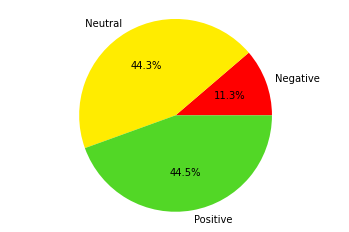

In [ ]:
print("Statistics on all the images of T4SA 2.0 without duplicates:")
plot_dataset_composition(t4sa2_without_duplicates, saving_name="img_t4sa2_no_duplicates.eps")

# Construction of bal_flat_T4SA2.0

Number of Positive: 959699
Number of Neutral: 927278
Number of Negative: 205589
Number below the confidence threshold: 873277


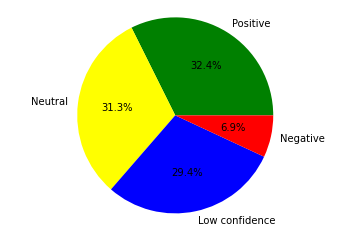

In [ ]:
# Load the file with all the text predictions
t4sa2_text_predictions = pd.read_csv(DATASET_T4SA2_DIR + "t4sa2.0_text_prediction_final.csv")

# Assign a label to all tweets considering a threshold on the confidence
# if the confidence is below the threshold is assigned the label "Too low"
t4sa2_text_predictions['label'] = t4sa2_text_predictions.apply(check_label_with_filter_flat, axis=1)

# Returns as a dict the label values
results = t4sa2_text_predictions["label"].value_counts().to_dict()
print("Number of Positive:", results["2"])
print("Number of Neutral:", results["1"])
print("Number of Negative:", results["0"])
print("Number below the confidence threshold:", results["Too low"])
labels = ["Positive", "Neutral", "Low confidence", "Negative"]
colors = ["green", "yellow", "blue", "red"]

fig1, ax1 = plt.subplots()
ax1.pie(results.values(),  labels=labels, colors=colors, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#plt.savefig(DATASET_DIR + "t4sa2_with_dup_no_filtered.eps", dpi=1200)
plt.show()

Plot statistic on the first version of t4sa2.0 before the balancing...
- Number of Positive: 1,055,910
- Number of Neutral:    859,047
- Number of Negative:   195,363
--------------------------------
Total:                2,110,320


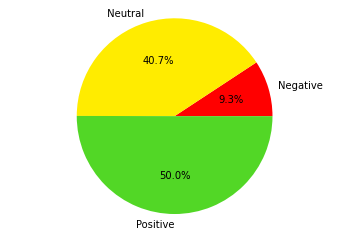

In [ ]:
# Load the dataframe from the file that contains the original predictions
imgs_t4sa2 = pd.read_csv(DATASET_T4SA2_DIR + "t4sa2.0_no_duplicates.csv").drop("label", axis=1)

# Remove all the tweets with a label below the confidence
t4sa2_text_predictions_filtered = t4sa2_text_predictions[t4sa2_text_predictions['label'] != "Too low"]

# Assign labels to images merging on the Tweet identifier
t4sa2_version_1 = pd.merge(imgs_t4sa2, t4sa2_text_predictions_filtered, how='left',left_on=['id_tweet'], right_on=['TWID']).drop(['TWID', "NEG", "NEU", "POS"], axis=1)

# Drop NaN values, which corresponds to images without label
t4sa2_version_1.dropna(inplace=True)

t4sa2_version_1["label"] = t4sa2_version_1["label"].apply(int) 

print("Plot statistic on the first version of t4sa2.0 before the balancing...")
plot_dataset_composition(t4sa2_version_1, saving_name=None)

## Balancing the dataset
Now we will balance only the dataset with a threshold on the confidence

Statistics on the version 1 T4SA 2.0 ('bal_flat_T4SA2'):
- Number of Positive:   195,363
- Number of Neutral:    195,363
- Number of Negative:   195,363
--------------------------------
Total:                  586,089


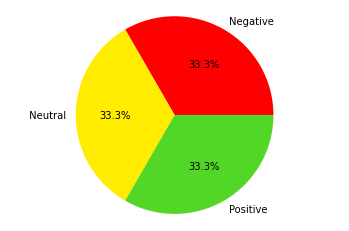

In [ ]:
t4sa2_version_1.drop("id_tweet", axis=1, inplace=True)

# We will balance the dataset randomly sampling from each class a 
# number of times equal to the cardinality of the lowest class
cardinality_lowest_class=min(t4sa2_version_1["label"].value_counts())

# Random sample a number of elements from each class equal to the cardinality of the lowest class (Negative)
t4sa2_version_1 = t4sa2_version_1.groupby('label').apply(lambda x: x.sample(n=cardinality_lowest_class)).reset_index(drop = True)
t4sa2_version_1.to_csv(DATASET_VERSION_1_DIR + "version_1_t4sa2_complete.csv", index=None)

print("Statistics on the version 1 T4SA 2.0 ('bal_flat_T4SA2.0'):")
plot_dataset_composition(t4sa2_version_1, saving_name="version_1_t4sa2.eps")

- Number of Positive:   156,290
- Number of Neutral:    156,290
- Number of Negative:   156,291
--------------------------------
Total:                  468,871


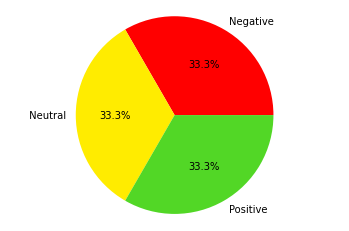

- Number of Positive:    19,536
- Number of Neutral:     19,537
- Number of Negative:    19,536
--------------------------------
Total:                   58,609


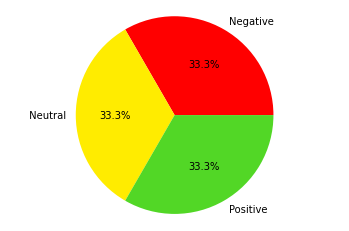

- Number of Positive:    19,537
- Number of Neutral:     19,536
- Number of Negative:    19,536
--------------------------------
Total:                   58,609


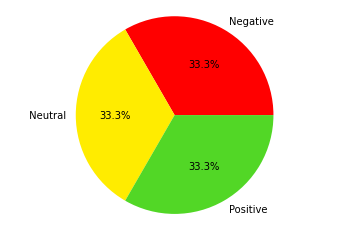

In [ ]:
# 80/10/10 train/val/test split
train_annot, valtest_annot = train_test_split(t4sa2_version_1, test_size=0.2, random_state=42, shuffle=True, stratify=t4sa2_version_1["label"])
val_annot, test_annot = train_test_split(valtest_annot, test_size=0.5, shuffle=True, stratify=valtest_annot["label"])

train_annot = train_annot.reset_index(drop=True)
val_annot = val_annot.reset_index(drop=True)
test_annot = test_annot.reset_index(drop=True)

plot_dataset_composition(train_annot, saving_name=None)
plot_dataset_composition(val_annot, saving_name=None)
plot_dataset_composition(test_annot, saving_name=None)

train_annot.to_csv(DATASET_VERSION_1_DIR + "version_1_t4sa2_train.csv", index=None)
val_annot.to_csv(DATASET_VERSION_1_DIR + "version_1_t4sa2_val.csv", index=None)
test_annot.to_csv(DATASET_VERSION_1_DIR + "version_1_t4sa2_test.csv", index=None)

# Construction of unb_T4SA2.0

Number of Positive: 625099
Number of Neutral: 235480
Number of Negative: 205589
Number below the confidence threshold: 1899675


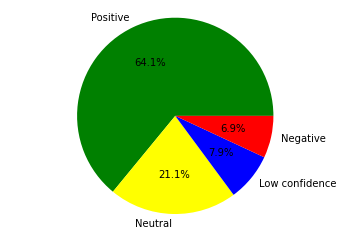

In [ ]:
# Load the file with all the text predictions
t4sa2_text_predictions = pd.read_csv(DATASET_T4SA2_DIR + "t4sa2.0_text_prediction_final.csv")

# Assign a label to all tweets considering a threshold on the confidence
# if the confidence is below the threshold is assigned the label "Too low"
t4sa2_text_predictions['label'] = t4sa2_text_predictions.apply(check_label_with_filter_70_90, axis=1)

# Returns as a dict the label values
results = t4sa2_text_predictions["label"].value_counts().to_dict()
print("Number of Positive:", results["2"])
print("Number of Neutral:", results["1"])
print("Number of Negative:", results["0"])
print("Number below the confidence threshold:", results["Too low"])
labels = ["Positive", "Neutral", "Low confidence", "Negative"]
colors = ["green", "yellow", "blue", "red"]

fig1, ax1 = plt.subplots()
ax1.pie(results.values(),  labels=labels, colors=colors, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Plot statistic on the second version of t4sa2.0...
- Number of Positive:   712,056
- Number of Neutral:    230,932
- Number of Negative:   195,363
--------------------------------
Total:                1,138,351


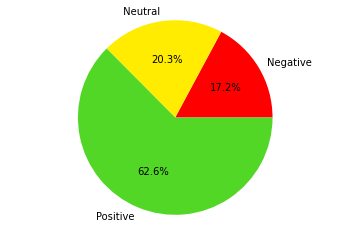

In [ ]:
# Load the dataframe from the file that contains the original predictions
imgs_t4sa2 = pd.read_csv(DATASET_T4SA2_DIR + "t4sa2.0_no_duplicates.csv").drop("label", axis=1)

# Remove all the tweets with a label below the confidence
t4sa2_text_predictions = t4sa2_text_predictions[t4sa2_text_predictions['label'] != "Too low"]

# Assign labels to images merging on the Tweet identifier
t4sa2_version_2 = pd.merge(imgs_t4sa2, t4sa2_text_predictions, how='left',left_on=['id_tweet'], right_on=['TWID']).drop(['TWID', "NEG", "NEU", "POS"], axis=1)

# Drop NaN values, which corresponds to images without label
t4sa2_version_2.dropna(inplace=True)

t4sa2_version_2["label"] = t4sa2_version_2["label"].apply(int) 

t4sa2_version_2.drop("id_tweet", axis=1, inplace=True)
t4sa2_version_2.to_csv(DATASET_VERSION_2_DIR + "version_2_t4sa2_complete.csv", index=None)

print("Plot statistic on the second version of t4sa2.0 (unb_T4SA2.0)...")
plot_dataset_composition(t4sa2_version_2, saving_name="version_2_t4sa2.eps")

- Number of Positive:   569,644
- Number of Neutral:    184,746
- Number of Negative:   156,290
--------------------------------
Total:                  910,680


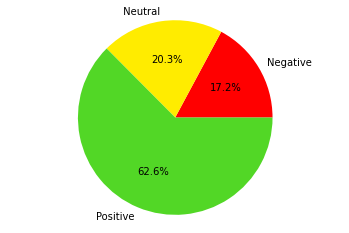

- Number of Positive:    71,206
- Number of Neutral:     23,093
- Number of Negative:    19,536
--------------------------------
Total:                  113,835


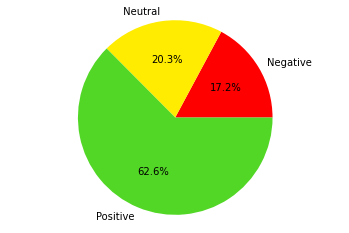

- Number of Positive:    71,206
- Number of Neutral:     23,093
- Number of Negative:    19,537
--------------------------------
Total:                  113,836


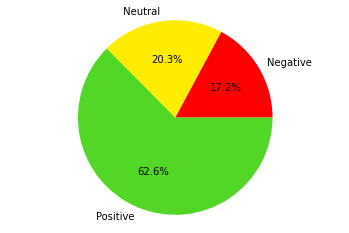

In [ ]:
# 80/10/10 train/val/test split
train_annot, valtest_annot = train_test_split(t4sa2_version_2, test_size=0.2, random_state=42, shuffle=True, stratify=t4sa2_version_2["label"])
val_annot, test_annot = train_test_split(valtest_annot, test_size=0.5, shuffle=True, stratify=valtest_annot["label"])

train_annot = train_annot.reset_index(drop=True)
val_annot = val_annot.reset_index(drop=True)
test_annot = test_annot.reset_index(drop=True)

plot_dataset_composition(train_annot, saving_name=None)
plot_dataset_composition(val_annot, saving_name=None)
plot_dataset_composition(test_annot, saving_name=None)

train_annot.to_csv(DATASET_VERSION_2_DIR + "version_2_t4sa2_train.csv", index=None)
val_annot.to_csv(DATASET_VERSION_2_DIR + "version_2_t4sa2_val.csv", index=None)
test_annot.to_csv(DATASET_VERSION_2_DIR + "version_2_t4sa2_test.csv", index=None)

## Construction of bal_T4SA2.0 - Balancing the dataset
Now we will balance only the dataset with a threshold on the confidence

Statistics on the version 3 T4SA 2.0 ('bal_T4SA2'):
- Number of Positive:   195,363
- Number of Neutral:    195,363
- Number of Negative:   195,363
--------------------------------
Total:                  586,089


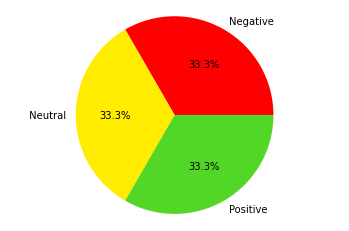

In [ ]:
# We will balance the dataset randomly sampling from each class a 
# number of times equal to the cardinality of the lowest class
cardinality_lowest_class=min(t4sa2_version_2["label"].value_counts())

# Random sample a number of elements from each class equal to the cardinality of the lowest class (Negative)
t4sa2_version_3 = t4sa2_version_2.groupby('label').apply(lambda x: x.sample(n=cardinality_lowest_class)).reset_index(drop = True)
t4sa2_version_3.to_csv(DATASET_VERSION_3_DIR + "version_3_t4sa2_complete.csv", index=None)

print("Statistics on the version 3 T4SA 2.0 ('bal_T4SA2.0'):")
plot_dataset_composition(t4sa2_version_3, saving_name="version_3_t4sa2.eps")

- Number of Positive:   156,290
- Number of Neutral:    156,290
- Number of Negative:   156,291
--------------------------------
Total:                  468,871


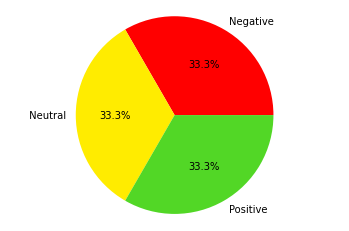

- Number of Positive:    19,536
- Number of Neutral:     19,537
- Number of Negative:    19,536
--------------------------------
Total:                   58,609


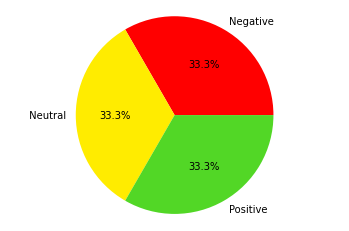

- Number of Positive:    19,537
- Number of Neutral:     19,536
- Number of Negative:    19,536
--------------------------------
Total:                   58,609


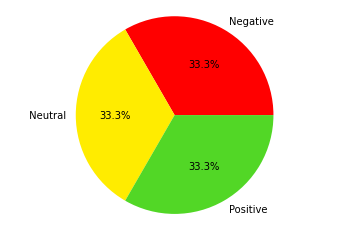

In [ ]:
# 80/10/10 train/val/test split
train_annot, valtest_annot = train_test_split(t4sa2_version_3, test_size=0.2, random_state=42, shuffle=True, stratify=t4sa2_version_3["label"])
val_annot, test_annot = train_test_split(valtest_annot, test_size=0.5, shuffle=True, stratify=valtest_annot["label"])

train_annot = train_annot.reset_index(drop=True)
val_annot = val_annot.reset_index(drop=True)
test_annot = test_annot.reset_index(drop=True)

plot_dataset_composition(train_annot, saving_name=None)
plot_dataset_composition(val_annot, saving_name=None)
plot_dataset_composition(test_annot, saving_name=None)

train_annot.to_csv(DATASET_VERSION_3_DIR + "version_3_t4sa2_train.csv", index=None)
val_annot.to_csv(DATASET_VERSION_3_DIR + "version_3_t4sa2_val.csv", index=None)
test_annot.to_csv(DATASET_VERSION_3_DIR + "version_3_t4sa2_test.csv", index=None)

# Costruction of merged_T4SA

- Number of Positive:   169,459
- Number of Neutral:    130,712
- Number of Negative:    64,576
--------------------------------
Total:                  364,747


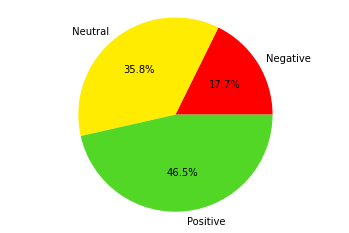

In [ ]:
bt4sa1= pd.read_csv(BT4SA1_DIR + "b-t4sa_all_filtered_70.tsv", delimiter="\t")
print("Statistics on the version  B-T4SA 1.0 updated and filtered:")
plot_dataset_composition(bt4sa1, saving_name="b-t4sa1_filtered.eps")

- Number of Positive:   881,515
- Number of Neutral:    361,644
- Number of Negative:   259,939
--------------------------------
Total:                1,503,098


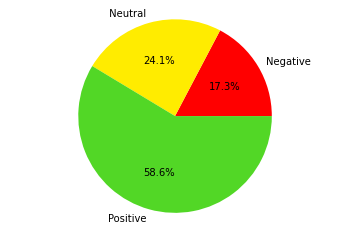

In [ ]:
t4sa_version_4 = pd.concat([t4sa2_version_2, bt4sa1], axis=0).reset_index(drop=True)
plot_dataset_composition(t4sa_version_4, saving_name="version_4_t4sa2.eps")

print("Statistics on the version 4 of T4SA 2.0 ('merged_T4SA'):")
t4sa_version_4.to_csv(DATASET_VERSION_4_DIR + "t4sa_version_4_complete.csv", index=None)

- Number of Positive:   705,212
- Number of Neutral:    289,315
- Number of Negative:   207,951
--------------------------------
Total:                1,202,478


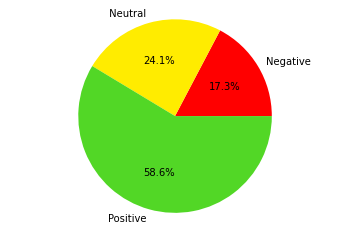

- Number of Positive:    88,152
- Number of Neutral:     36,164
- Number of Negative:    25,994
--------------------------------
Total:                  150,310


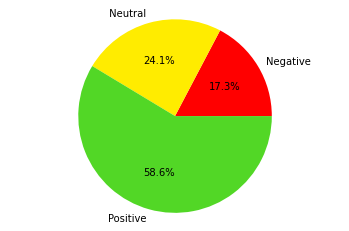

- Number of Positive:    88,151
- Number of Neutral:     36,165
- Number of Negative:    25,994
--------------------------------
Total:                  150,310


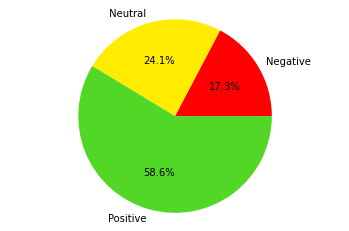

In [ ]:
# 80/10/10 train/val/test split
train_annot, valtest_annot = train_test_split(t4sa_version_4, test_size=0.2, random_state=42, shuffle=True, stratify=t4sa_version_4["label"])
val_annot, test_annot = train_test_split(valtest_annot, test_size=0.5, shuffle=True, stratify=valtest_annot["label"])

train_annot = train_annot.reset_index(drop=True)
val_annot = val_annot.reset_index(drop=True)
test_annot = test_annot.reset_index(drop=True)

plot_dataset_composition(train_annot, saving_name=None)
plot_dataset_composition(val_annot, saving_name=None)
plot_dataset_composition(test_annot, saving_name=None)

train_annot.to_csv(DATASET_VERSION_4_DIR + "t4sa_version_4_train.csv", index=None)
val_annot.to_csv(DATASET_VERSION_4_DIR + "t4sa_version_4_val.csv", index=None)
test_annot.to_csv(DATASET_VERSION_4_DIR + "t4sa_version_4_test.csv", index=None)